In [1]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Eval checkpoint driver.

This is an example evaluation script for users to understand the EfficientNet
model checkpoints on CPU. To serve EfficientNet, please consider to export a
`SavedModel` from checkpoints and use tf-serving to serve.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import sys
from absl import app
from absl import flags
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()



import efficientnet_builder
import preprocessing


# flags.DEFINE_string('model_name', 'efficientnet-b0', 'Model name to eval.')
# flags.DEFINE_string('runmode', 'examples', 'Running mode: examples or imagenet')
# flags.DEFINE_string('imagenet_eval_glob', None,
#                     'Imagenet eval image glob, '
#                     'such as /imagenet/ILSVRC2012*.JPEG')
# flags.DEFINE_string('imagenet_eval_label', None,
#                     'Imagenet eval label file path, '
#                     'such as /imagenet/ILSVRC2012_validation_ground_truth.txt')
# flags.DEFINE_string('ckpt_dir', '/tmp/ckpt/', 'Checkpoint folders')
# flags.DEFINE_string('example_img', '/tmp/panda.jpg',
#                     'Filepath for a single example image.')
# flags.DEFINE_string('labels_map_file', '/tmp/labels_map.txt',
#                     'Labels map from label id to its meaning.')
# flags.DEFINE_integer('num_images', 5000,
#                      'Number of images to eval. Use -1 to eval all images.')
# FLAGS = flags.FLAGS

In [51]:
MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]


model_name='efficientnet-b0'
batch_size=16
"""Initialize internal variables."""
model_name = model_name
batch_size = batch_size
num_classes = 1000
# Model Scaling parameters
_, _, image_size, _ = efficientnet_builder.efficientnet_params(
      model_name)
print('image_size', image_size)

def restore_model(sess, ckpt_dir):
  """Restore variables from checkpoint dir."""
  checkpoint = tf.train.latest_checkpoint(ckpt_dir)
  ema = tf.train.ExponentialMovingAverage(decay=0.9999)
  ema_vars = tf.trainable_variables() + tf.get_collection('moving_vars')
  for v in tf.global_variables():
    if 'moving_mean' in v.name or 'moving_variance' in v.name:
      ema_vars.append(v)
  ema_vars = list(set(ema_vars))
  var_dict = ema.variables_to_restore(ema_vars)
  saver = tf.train.Saver(var_dict, max_to_keep=1)
  saver.restore(sess, checkpoint)

def build_model( features, is_training):
  """Build model with input features."""
#   features -= tf.constant(MEAN_RGB, shape=[1, 1, 3], dtype=features.dtype)
#   features /= tf.constant(STDDEV_RGB, shape=[1, 1, 3], dtype=features.dtype)
  out, _ = efficientnet_builder.build_model_base(
      features, model_name, is_training)
  return out

def build_dataset(filenames, labels, is_training):
  """Build input dataset."""
  filenames = tf.constant(filenames)
  labels = tf.constant(labels)
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

  def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = preprocessing.preprocess_image(
        image_string, is_training, image_size=image_size)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

  dataset = dataset.map(_parse_function)
  dataset = dataset.batch(batch_size)

  iterator = dataset.make_one_shot_iterator()
  images, labels = iterator.get_next()
  return images, labels

image_size 224


W0621 00:05:51.039052 4739323328 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234
(4, 224, 224, 3) tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]], shape=(4, 5), dtype=float64)


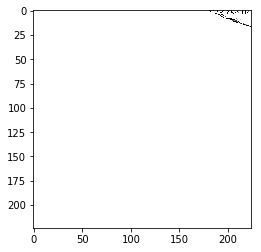

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images, labls in dataset.repeat(samples_per_image).batch(n_images):
        print(images.shape, labls)
        break
#         output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
#         row += 1

    plt.figure()
    plt.imshow(images[0])
    plt.show()
training_files, labels = get_data()    
training_files = tf.constant(training_files)
labels = tf.constant(labels, shape=[234, 5])
dataset = tf.data.Dataset.from_tensor_slices((training_files, labels))
def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = preprocessing.preprocess_image(
      image_string, False, image_size=image_size)
  image = tf.cast(image_decoded, tf.float32)
  return image, label

dataset = dataset.map(_parse_function)
plot_images(dataset, n_images=4, samples_per_image=10)

In [36]:
3.06187500e+02

306.1875

In [52]:
training_files, labels = get_data()
graph = tf.Graph()
with tf.Session(graph=graph) as sess:
  images, labels = build_dataset(training_files, labels, False)
  out = build_model(images, is_training=False)
  out = tf.reduce_mean(out, axis=[1,2])
  sess.run(tf.global_variables_initializer())
  restore_model(sess, './weights_efficientnet-b0/')
  
  temp = set(tf.all_variables())
  
  logits = tf.contrib.layers.fully_connected(out, 5, activation_fn=None)

  logits = tf.math.sigmoid(logits, name = 'sigmoid_logits')
  cross_entropy = tf.losses.sigmoid_cross_entropy(logits=logits,
                                                  multi_class_labels=labels)
  weight_decay = 1e-5
  loss = cross_entropy + weight_decay * tf.add_n(
      [tf.nn.l2_loss(v) for v in tf.trainable_variables()
       if 'batch_normalization' not in v.name])
  
  lr = 0.01
  optimizer = tf.train.AdamOptimizer(learning_rate=lr, name="adam").minimize(loss)
  
  sess.run(tf.initialize_variables(set(tf.all_variables()) - temp))
  for i in range(len(training_files)//batch_size):
    lss, _ = sess.run([loss, optimizer])
    print(lss)

W0621 00:06:13.836422 4739323328 deprecation.py:506] From /Users/midhunpk/Documents/artelus/efficientnet/lib/python2.7/site-packages/tensorflow/python/framework/function.py:1007: calling create_op (from tensorflow.python.framework.ops) with compute_shapes is deprecated and will be removed in a future version.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


234
###
###
###
###
###
###
###
###
###
###
###
###
###
###
###
###


W0621 00:07:36.610641 4739323328 deprecation.py:323] From /Users/midhunpk/Documents/artelus/efficientnet/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0621 00:07:36.939127 4739323328 deprecation.py:323] From <ipython-input-52-12efab96f1e1>:10: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.
W0621 00:07:36.962785 4739323328 deprecation.py:323] From /Users/midhunpk/Documents/artelus/efficientnet/lib/python2.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
W0621 00:07

1.0415505
1.0326006
1.0754901
1.0489991
0.9445638
0.8205646
0.9939699
0.75426775
0.7495252
0.74650896
0.74362624
0.7412493
0.8382993
0.81164426


In [ ]:
np.save('file4.npy', np.array(out_probs)) 

In [ ]:
for op in graph.get_operations():
     print(op.name)

In [ ]:
np.array(out_probs).shape

In [3]:
import pandas as pd
import numpy as np

def get_data():
  path = './'
  train = pd.read_csv(path+'./CheXpert-v1.0-small/train.csv')
  valid = pd.read_csv(path+'./CheXpert-v1.0-small/valid.csv')
  
  train['validation'] = False
  valid['validation'] = True
  df = pd.concat([train, valid])
  
  columns = ['Path', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion', 'validation']
  df = df[columns]
  
  for feature in ['Atelectasis', 'Edema']:
      df[feature] = df[feature].apply(lambda x: 1 if x==-1 else x)
  
  for feature in ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']:
      df[feature] = df[feature].apply(lambda x: 0 if x==-1 else x)
  df.fillna(0, inplace=True)
  
  train = df[~df.validation]
  print(len(train))
  files = train['Path'].tolist()
  files = [path+fil for fil in files]
  
  columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
  labels = np.array(train[columns])
  
  return files, labels

In [ ]:
training_files = files

In [ ]:
labels.shape